# Keras VGG16 Feature Extraction #


#### import necessary packages ####

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os

####  Define the Feature Extraction Function ####

In [5]:
def extract_features(model, folder_path):
    # Get a list of all image files in the folder
    img_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Use list comprehension to process images and extract features
    features = []
    for img_path in img_paths:
        try:
            img = image.load_img(img_path, target_size=model.input_shape[1:3])
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            feature = model.predict(img_array)
            features.append(feature)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    # Stack the extracted features into a single NumPy array
    features = np.vstack(features)

    return features


#### Load Pre-trained VGG16 Model and Create Feature Extraction Model ####

In [6]:
# Load the pre-trained VGG16 model with top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))  # Adjust input_shape accordingly

# Create a new model that includes only the convolutional base of VGG16
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)


#### Specify Folder Paths ####

In [7]:
# Specify folder paths for ASD and non-ASD child face image sets
asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD'
non_asd_folder_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD'

#### Extract Features for ASD Child Faces ####

In [8]:
# Extract features for ASD child faces
asd_features = extract_features(model, asd_folder_path)


2024-02-09 12:35:49.940089: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 150ms/step


KeyboardInterrupt: 

#### Extract Features for Non-ASD Child Faces ####

In [8]:
# Extract features for non-ASD child faces
non_asd_features = extract_features(model, non_asd_folder_path)


1/1 [==============================] - 0s 277ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/child-1617.png: cannot identify image file <_io.BytesIO object at 0x2830af1a0>
1/1 [==============================] - 0s 288ms/step
Error processing image /Users/isurudissanayake/Documents/Data/DATA_SET/NON-ASD/additional1178.png: cannot identify image file <_io.BytesIO object at 0x16b873330>
1/1 [==============================] - 0s 269ms/step


#### Save Extracted Features ####

In [9]:
# Save the extracted features for later use in training
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/asd_features.npy', asd_features)
np.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/non_asd_features.npy', non_asd_features)


# Model Training VGG16 #

#### import necessary packages ####

In [10]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model

#### Load the extracted features for ASD and non-ASD child faces ####

In [11]:
asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/asd_features.npy')
non_asd_features = np.load('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/non_asd_features.npy')

#### Assign labels (1 for ASD, 0 for non-ASD) ####

In [12]:
asd_labels = np.ones(asd_features.shape[0])
non_asd_labels = np.zeros(non_asd_features.shape[0])

#### Combine features and labels ####

In [13]:
X = np.vstack([asd_features, non_asd_features])
y = np.concatenate([asd_labels, non_asd_labels])

#### Shuffle the data ####

In [14]:
X, y = shuffle(X, y, random_state=42)

#### Split the data into training and testing sets (70% training, 30% testing) ####

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Model definition ####

In [18]:
model = Sequential()
model.add(Flatten(input_shape=(14, 14, 512)))  # Adjust input shape to match the flattened features
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Model training ####

In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
172/172 [==============================] - 49s 268ms/step - loss: 3.6219 - accuracy: 0.8662 - val_loss: 0.2719 - val_accuracy: 0.8932
Epoch 2/100
172/172 [==============================] - 40s 231ms/step - loss: 0.2191 - accuracy: 0.9209 - val_loss: 0.2706 - val_accuracy: 0.9113
Epoch 3/100
172/172 [==============================] - 195s 1s/step - loss: 0.1634 - accuracy: 0.9368 - val_loss: 0.2603 - val_accuracy: 0.9179
Epoch 4/100
172/172 [==============================] - 55s 316ms/step - loss: 0.1327 - accuracy: 0.9491 - val_loss: 0.3342 - val_accuracy: 0.9099
Epoch 5/100
172/172 [==============================] - 49s 281ms/step - loss: 0.0983 - accuracy: 0.9571 - val_loss: 0.3373 - val_accuracy: 0.9135
Epoch 6/100
172/172 [==============================] - 47s 272ms/step - loss: 0.0950 - accuracy: 0.9646 - val_loss: 0.3654 - val_accuracy: 0.9150
Epoch 7/100
172/172 [==============================] - 45s 263ms/step - loss: 0.0881 - accuracy: 0.9635 - val_loss: 0.4136 - v

 #### Save the trained model to a file named 'VGG16Model.h5' ####

In [20]:
model.save('/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5')

/Users/isurudissanayake/Library/Mobile Documents/com~apple~CloudDocs/IIT/4th_Year/4_2/FYP/Implementation/FYP_Implementation/FYP_Impl/env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Model evaluation ####


In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

93/93 [==============================] - 4s 29ms/step - loss: 1.2991 - accuracy: 0.9220
Test Accuracy: 0.9220074415206909


# Keras VGG16 Prediction #

#### Importing Libraries and  ####

In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model


#### Defining Paths and target size ####

In [2]:
# Define paths
input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0486.jpg'  # Replace with your image path
# input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/test.jpeg'  # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

#### Load Pre-trained VGG16 Model and Create a New Model ####

In [3]:
# Load the pre-trained VGG16 model with top layers included
base_model = VGG16(weights='imagenet', include_top=True)

# Create a new model that takes the input of VGG16 and outputs the desired layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)


#### Process Input Image and Extract Features ####

In [4]:
# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size)
img = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))

# Extract features using the full VGG16 model
features = model.predict(img)  # Use the new model
# Use base_model directly for feature extraction
# features = base_model.predict(img)


1/1 [==============================] - 3s 3s/step


#### Reshape Features and Load Trained Model ####


In [5]:
# Reshape features to match the expected input shape of trained_model
features_reshaped = np.reshape(features, (features.shape[0], 14, 14, 512))  # Reshape to (None, 14, 14, 512)

# Load the trained model
trained_model = load_model(model_path)

#### Predict ASD Probability and Interpret the Prediction ####

In [6]:
# Predict ASD probability using the trained model and extracted features
prediction = trained_model.predict(features_reshaped)[0][0]  # Access the first element for ASD probability
print("prediction: ", prediction)
print("prediction: {:.5f}".format(prediction))

# Interpret the prediction
rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")
else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")


1/1 [==============================] - 1s 714ms/step
prediction:  1.0
prediction: 1.00000
Predicted probability: 1.00
Predicted ASD with probability: 1.00


1/1 [==============================] - 1s 1s/step
Predicted probability: 0.62
Predicted ASD with probability: 0.62


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


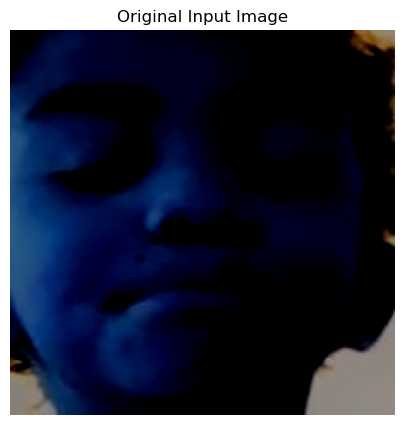

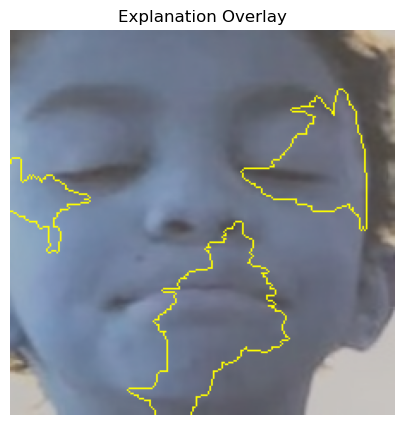

In [2]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2
import numpy as np
from lime.lime_image import LimeImageExplainer

input_image_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0576.jpg' # Replace with your image path
model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
target_size = (224, 224)

# Load the pre-trained VGG16 model with top layers included
base_model = VGG16(weights='imagenet', include_top=True)

# Take the output of the base model up to the last convolutional layer
x = base_model.get_layer('block5_pool').output

# Add a new dense layer for output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create a new model that takes the input of VGG16 and outputs the desired layer/
model = Model(inputs=base_model.input, outputs=predictions)

# Process the input image
img = cv2.imread(input_image_path)
img = cv2.resize(img, target_size) # Resize the image to (224, 224)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
img = np.expand_dims(img, axis=0) # Add a batch dimension
img = preprocess_input(img) # Preprocess the image

# Preprocess the image for the explainer by dividing pixel values by 255
img_scaled = img / 255.0

# Predict ASD probability using the full VGG16 model
prediction = model.predict(img)[0][0] # Access the first element for ASD probability

rounded_prediction = round(prediction, 2)
print(f"Predicted probability: {rounded_prediction:.2f}")

if rounded_prediction > 0.5:
    print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

    explainer = LimeImageExplainer()

    # Generate an explanation for the prediction using the explainer object
    explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0, num_samples=10000, random_seed=42)

    # Visualize the explanation using matplotlib
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    # plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    
     # Plot the original input image
    plt.figure(figsize=(5,5))
    plt.imshow(img_scaled[0])
    plt.title('Original Input Image')
    plt.axis('off')
    plt.show()
    
    # Plot the explanation using mark_boundaries
    plt.figure(figsize=(5,5))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Explanation Overlay')
    plt.axis('off')
    plt.show()

else:
    print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")

1/1 [==============================] - 0s 292ms/step
Predicted probability: 0.64
Predicted ASD with probability: 0.64


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


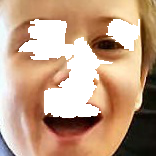

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.segmentation import mark_boundaries
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from PIL import Image
from pathlib import Path
from IPython.display import display
from lime.lime_image import LimeImageExplainer

def show_image(image):
    # Display the image inline
    display(Image.fromarray(image))

# Provide the path to your image file
image_path = "/Users/isurudissanayake/Documents/Data/DATA_SET/ASD/0579.jpg"

# Check if the file exists
if Path(image_path).is_file():
    model_path = '/Users/isurudissanayake/Documents/Data/DATA_SET/Feature-Extraction/VGG16/VGG16Model.h5'
    target_size = (224, 224)

    # Load the pre-trained VGG16 model with top layers included
    base_model = VGG16(weights='imagenet', include_top=True)

    # Take the output of the base model up to the last convolutional layer
    x = base_model.get_layer('block5_pool').output

    # Add a new dense layer for output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create a new model that takes the input of VGG16 and outputs the desired layer
    model = Model(inputs=base_model.input, outputs=predictions)

    # Process the input image
    img = np.array(Image.open(image_path).resize(target_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Preprocess the image for the explainer by dividing pixel values by 255
    img_scaled = img / 255.0

    # Predict ASD probability using the full VGG16 model
    prediction = model.predict(img)[0][0]  # Access the first element for ASD probability

    rounded_prediction = round(prediction, 2)
    print(f"Predicted probability: {rounded_prediction:.2f}")

    if rounded_prediction > 0.5:
        print(f"Predicted ASD with probability: {rounded_prediction:.2f}")

        explainer = LimeImageExplainer()

        # Generate an explanation for the prediction using the explainer object
        explanation = explainer.explain_instance(img_scaled[0], model.predict, top_labels=1, hide_color=0,
                                                  num_samples=10000, random_seed=42)

        # Visualize the explanation using matplotlib
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5,
                                                    hide_rest=False)

        # Resize the explanation mask to match the original image dimensions
        mask = cv2.resize(mask, (target_size[0], target_size[1]), interpolation=cv2.INTER_NEAREST)

        # Convert the mask to the original image mode
        original_image = Image.open(image_path)
        #original_image = original_image.convert("L")  # Convert the original image to grayscale
        original_width, original_height = original_image.size
        original_mode = original_image.mode

        # Overlay the explanation mask on the original image
        mask = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
        original_image = np.array(original_image)
        original_image[mask > 0.5] = 255

        # Display the original image with the explanation mask
        show_image(original_image)

    else:
        print(f"Predicted non-ASD with probability: {1 - rounded_prediction:.2f}")
else:
    print("Error: Image file not found.")